In [1]:
%load_ext autoreload
%autoreload 2

## detecting and cropping faces

In [2]:
done = False
done = True
from gaze import init, Data
args = init(batch_size=8, verbose=1)
d = Data(args)

Trying to load cuda, but it is not available
no cuda? True
Found 1117 sample images;  894  to train 223 to test


In [3]:
import os
import glob
datapath_faces = 'dataset_faces'
datapath = 'dataset'

if True:
    n_show = 10
    for target in d.classes:
        for filename in glob.glob(os.path.join(datapath, target) + '/*.png')[-n_show:]:
            print(filename)

dataset/blink/2018-09-05_Laurent_090.png
dataset/blink/2018-09-12_Laurent_035.png
dataset/blink/2018-09-12_Laurent_223.png
dataset/blink/2018-09-12_Laurent_237.png
dataset/blink/2018-09-12_Laurent_222.png
dataset/blink/2018-09-14_Laurent_121.png
dataset/blink/2018-09-04_Laurent_180.png
dataset/blink/2018-09-12_Laurent_020.png
dataset/blink/2018-09-05_Laurent_085.png
dataset/blink/2018-09-14_Laurent_069.png
dataset/center/2018-09-05_Laurent_244.png
dataset/center/2018-09-05_Laurent_091.png
dataset/center/2018-09-04_Laurent_16.png
dataset/center/2018-09-12_Laurent_140.png
dataset/center/2018-09-14_Laurent_243.png
dataset/center/2018-09-12_Laurent_168.png
dataset/center/2018-09-12_Laurent_183.png
dataset/center/2018-09-04_Laurent_221.png
dataset/center/2018-09-04_Laurent_235.png
dataset/center/2018-09-14_Laurent_096.png
dataset/left/2018-09-14_Laurent_108.png
dataset/left/2018-09-12_Laurent_236.png
dataset/left/2018-09-05_Laurent_091.png
dataset/left/2018-09-12_Laurent_008.png
dataset/lef

In [4]:
import imageio
try:
    os.mkdir(datapath_faces)
except:
    pass

for target in d.classes:
    try:
        os.mkdir(os.path.join(datapath_faces, target))
        print('Creating folder ', os.path.join(datapath_faces, target))
    except:
        pass


In [5]:
if not done:
    import time
    import dlib
    detector = dlib.get_frontal_face_detector()
    timings = []
    for target in d.classes:
        for filename in glob.glob(os.path.join(datapath, target) + '/*.png'):
            frame = imageio.imread(filename)
            t0 = time.time()
            N_X, N_Y, three = frame.shape
            dets = detector(frame, 1)
            d = dets[0]
            face = frame[(d.top()):(d.bottom()), (d.left()):(d.right()), :]
            t1 = time.time()
            timings.append(t1-t0)
            if False:
                print("Number of faces detected: {}".format(len(dets)))
                for i, d in enumerate(dets):
                    print("Detection {}: Left: {} Top: {} Right: {} Bottom: {}".format(
                        i, d.left(), d.top(), d.right(), d.bottom()))

            if False:
                # Create figure and axes
                fig, ax = plt.subplots(figsize=(15, 8))

                # Display the image
                ax.imshow(frame)

                # Create a Rectangle patch
                rect = patches.Rectangle((d.bottom(), d.left()), d.right()-d.left(), d.top()-d.bottom(), linewidth=1, edgecolor='r', facecolor='none')

                # Add the patch to the Axes
                ax.add_patch(rect)
                plt.show()    
            if False:
                # Create figure and axes
                fig, ax = plt.subplots(figsize=(15, 8))

                # Display the cropped image
                ax.imshow(face)

                plt.show()                

            filename_face = filename.replace(datapath, datapath_faces)
            imageio.imwrite(filename_face, face) 


## running the model on the cropped faces

In [6]:
from gaze import init
epochs = 40
args = init(verbose=0, epochs=epochs)
print('Parameters=', args)

path = '_Regard.pt'

Parameters= {'dataset_folder': 'dataset_faces', 'batch_size': 8, 'test_batch_size': 1, 'size_test_set': 0.2, 'epochs': 40, 'do_adam': False, 'lr': 0.025, 'momentum': 0.05, 'no_cuda': False, 'num_processes': 1, 'seed': 42, 'log_interval': 0, 'fullsize': 64, 'crop': 64, 'size': 64, 'mean': 0.36, 'std': 0.3, 'conv1_dim': 9, 'conv1_kernel_size': 18, 'conv2_dim': 36, 'conv2_kernel_size': 14, 'stride1': 2, 'stride2': 4, 'N_cv': 20, 'dimension': 30, 'verbose': 0}


In [7]:
!ls -l {path}
#!rm {path}

ls: _Regard.pt: No such file or directory


In [8]:
from gaze import ML
ml = ML(args)

import os
import torch
if os.path.isfile(path):
    ml.model.load_state_dict(torch.load(path))
    print('Loading file', path)
else:
    print('Training model...')
    ml.train()
    torch.save(ml.model.state_dict(), path) #save the neural network state
    print('Model saved at', path)

Training model...
Model saved at _Regard.pt


## testing the model

In [9]:
Accuracy = ml.test()
print('Accuracy={:.1f}%'.format(Accuracy*100))

Accuracy=97.3%


Showing the one which are wrong:

target:right
pred  :center


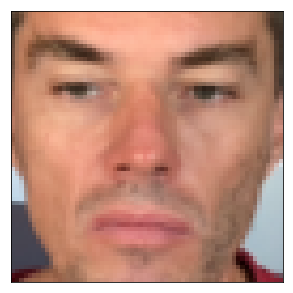

target:right
pred  :center


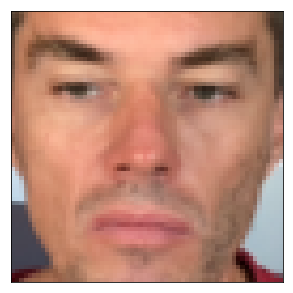

target:blink
pred  :center


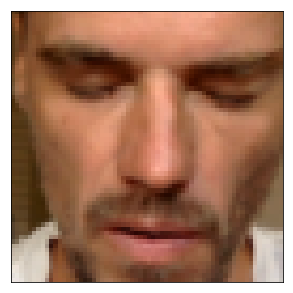

target:center
pred  :blink


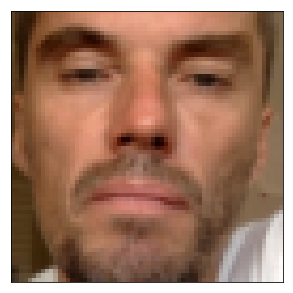

target:center
pred  :blink


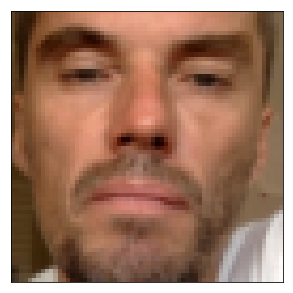

target:right
pred  :center


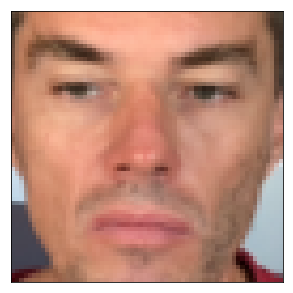

target:blink
pred  :center


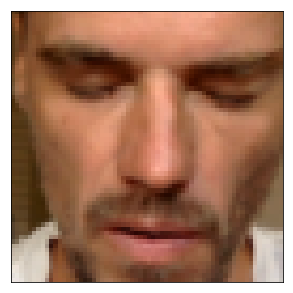

target:center
pred  :blink


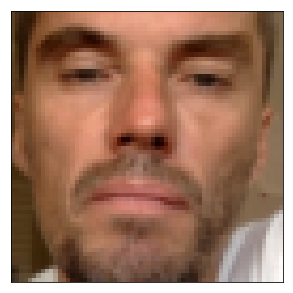

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

for data, labels in ml.dataset.test_loader:
    fig, ax = ml.show(only_wrong=True)
    plt.show() 
